In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading

In [2]:
# Load monthly district data
df_monthly = pd.read_csv('../outputs/df_monthly_district.csv')

# Load Layer 1 migration metrics
df_migration = pd.read_csv('../outputs/layer1_migration_metrics.csv')

print(f"Monthly data: {df_monthly.shape}")
print(f"Migration metrics: {df_migration.shape}")
print(f"\nChild age groups: demo_age_5_17")
print(f"Adult age groups: demo_age_17_")

df_monthly.head()

Monthly data: (7062, 9)
Migration metrics: (1056, 16)

Child age groups: demo_age_5_17
Adult age groups: demo_age_17_


,year_month,state,district,demo_age_5_17,demo_age_17_,record_count,pincode_count,total_updates,child_update_share
0,2025-03,Andaman And Nicobar Islands,Nicobar,16,180,1,1,196,8.163261
1,2025-03,Andaman And Nicobar Islands,North And Middle Andaman,10,201,1,1,211,4.739334
2,2025-03,Andaman And Nicobar Islands,South Andaman,88,514,5,5,602,14.617938
3,2025-03,Andhra Pradesh,Adilabad,457,5481,27,20,5938,7.696194
4,2025-03,Andhra Pradesh,Alluri Sitharama Raju,408,3291,12,9,3699,11.030008


## 2. Layer 2 Metric Calculations

### Key Metrics:
1. **Child Update Share**: Proportion of child vs adult updates
2. **Child-Adult Lag Index**: Temporal lag between adult spike and child response
3. **Update Gap Magnitude**: Difference in update volumes
4. **Child Risk Score**: Composite welfare access indicator

In [3]:
# Calculate district-level child risk metrics
child_risk_metrics = []

for (district, state), group in df_monthly.groupby(['district', 'state']):
    group = group.sort_values('year_month')
    
    adult_values = group['demo_age_17_'].values
    child_values = group['demo_age_5_17'].values
    
    # Basic statistics
    mean_adult = adult_values.mean()
    mean_child = child_values.mean()
    std_adult = adult_values.std()
    std_child = child_values.std()
    
    # 1. Child Update Share
    total_updates = adult_values.sum() + child_values.sum()
    child_share = (child_values.sum() / total_updates * 100) if total_updates > 0 else 0
    
    # 2. Child-Adult Ratio (monthly average)
    ratios = []
    for i in range(len(child_values)):
        if adult_values[i] > 0:
            ratios.append(child_values[i] / adult_values[i])
    avg_child_adult_ratio = np.mean(ratios) if ratios else 0
    
    # 3. Update Gap Magnitude (absolute difference)
    update_gaps = adult_values - child_values
    avg_update_gap = update_gaps.mean()
    max_update_gap = update_gaps.max()
    
    # 4. Lag Detection (cross-correlation)
    # Detect if adult spike precedes child spike
    if len(adult_values) > 3 and std_adult > 0 and std_child > 0:
        # Normalize for correlation
        adult_norm = (adult_values - mean_adult) / std_adult
        child_norm = (child_values - mean_child) / std_child
        
        # Cross-correlation to detect lag
        correlation = np.correlate(adult_norm, child_norm, mode='full')
        lags = np.arange(-len(adult_norm) + 1, len(adult_norm))
        lag_index = lags[correlation.argmax()]
        max_correlation = correlation.max() / len(adult_norm)
    else:
        lag_index = 0
        max_correlation = 0
    
    # 5. Volatility Imbalance (adult volatile but child stable = lag)
    volatility_imbalance = std_adult - std_child
    cv_adult = (std_adult / mean_adult) if mean_adult > 0 else 0
    cv_child = (std_child / mean_child) if mean_child > 0 else 0
    cv_imbalance = cv_adult - cv_child
    
    # 6. Spike Response Pattern
    # Check if adult peak months have corresponding child peaks
    if len(adult_values) > 2:
        adult_peaks, _ = find_peaks(adult_values, prominence=mean_adult * 0.2)
        child_peaks, _ = find_peaks(child_values, prominence=mean_child * 0.2 if mean_child > 0 else 1)
        
        peak_mismatch = len(adult_peaks) - len(child_peaks)
        has_adult_spike = len(adult_peaks) > 0
        has_child_response = len(child_peaks) > 0
    else:
        peak_mismatch = 0
        has_adult_spike = False
        has_child_response = False
    
    # 7. Child Risk Score (composite)
    # Higher score = higher risk
    # Components: low child share + high gap + high imbalance + positive lag
    risk_components = [
        (100 - child_share) / 100,  # Lower child share = higher risk
        min(cv_imbalance, 2) / 2,   # Volatility imbalance (capped at 2)
        min(peak_mismatch, 5) / 5,   # Peak mismatch (capped at 5)
        1 if lag_index > 0 else 0    # Positive lag = risk
    ]
    child_risk_score = np.mean(risk_components) * 100
    
    # Risk classification
    if child_risk_score > 70:
        risk_level = 'Critical'
    elif child_risk_score > 50:
        risk_level = 'High'
    elif child_risk_score > 30:
        risk_level = 'Moderate'
    else:
        risk_level = 'Low'
    
    child_risk_metrics.append({
        'district': district,
        'state': state,
        'mean_adult_updates': mean_adult,
        'mean_child_updates': mean_child,
        'child_share_pct': child_share,
        'avg_child_adult_ratio': avg_child_adult_ratio,
        'avg_update_gap': avg_update_gap,
        'max_update_gap': max_update_gap,
        'lag_index': lag_index,
        'lag_correlation': max_correlation,
        'volatility_imbalance': volatility_imbalance,
        'cv_imbalance': cv_imbalance,
        'peak_mismatch': peak_mismatch,
        'has_adult_spike': has_adult_spike,
        'has_child_response': has_child_response,
        'child_risk_score': child_risk_score,
        'risk_level': risk_level,
        'num_months': len(group)
    })

df_child_risk = pd.DataFrame(child_risk_metrics)

# Merge with migration metrics
df_child_risk = df_child_risk.merge(df_migration[['district', 'state', 'volatility', 'migration_pattern']], 
                                     on=['district', 'state'], how='left')

print(f"Child risk metrics calculated for {len(df_child_risk)} districts")
print(f"\nRisk Level Distribution:")
print(df_child_risk['risk_level'].value_counts())

df_child_risk.head(10)

Child risk metrics calculated for 1056 districts

Risk Level Distribution:
risk_level
Low         954
Moderate     93
High          9
Name: count, dtype: int64


,district,state,mean_adult_updates,mean_child_updates,child_share_pct,avg_child_adult_ratio,avg_update_gap,max_update_gap,lag_index,lag_correlation,volatility_imbalance,cv_imbalance,peak_mismatch,has_adult_spike,has_child_response,child_risk_score,risk_level,num_months,volatility,migration_pattern
0,100000,100000,3.000000,0.000000,0.000000,0.000000,3.000000,3,0,0.000000,0.000000,0.000000,0,False,False,25.000000,Low,1,0.000000,Stable Population
1,561203,561203,1.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.000000,0.000000,0.000000,0,False,False,25.000000,Low,1,0.000000,Stable Population
2,5Th Cross,Puttenahalli,2.000000,0.000000,0.000000,0.000000,2.000000,2,0,0.000000,0.000000,0.000000,0,False,False,25.000000,Low,1,0.000000,Stable Population
3,Adilabad,Andhra Pradesh,4576.500000,356.666667,7.229974,0.073216,4219.833333,6701,0,0.911956,1868.909363,-0.004019,0,True,True,23.142268,Low,6,2028.427038,Stable Population
4,Adilabad,Telangana,4205.777778,615.444444,12.765320,0.149149,3590.333333,6801,0,0.944872,2465.717506,-0.004861,1,True,True,26.747903,Low,9,2891.888340,Seasonal Migration
5,Agar Malwa,Madhya Pradesh,982.111111,99.777778,9.222553,0.118185,882.333333,1936,0,0.893570,572.700465,0.193932,0,True,True,25.118515,Low,9,615.925400,Seasonal Migration
6,Agra,Uttar Pradesh,20318.777778,2065.555556,9.227684,0.114249,18253.222222,54343,0,0.800163,16523.253261,0.091988,0,True,True,23.842927,Low,9,18181.536250,High In-Migration
7,Ahilyanagar,Maharashtra,886.500000,62.000000,6.536637,0.042614,824.500000,2921,0,0.998776,1212.361998,-0.081587,0,True,True,22.346003,Low,4,1308.966864,Seasonal Migration
8,Ahmadabad,Gujarat,1629.600000,54.400000,3.230404,0.038152,1575.200000,3172,3,0.581880,1051.170393,-0.120995,0,True,True,47.679957,Moderate,5,1094.282340,Seasonal Migration
9,Ahmadnagar,Maharashtra,36523.000000,1252.000000,3.314361,0.061113,35271.000000,112645,0,0.688901,36590.682684,0.532421,-1,True,True,25.826674,Low,6,37199.273953,High In-Migration


## 3. Summary Statistics

In [4]:
print("=" * 80)
print("LAYER 2: CHILD DOCUMENTATION RISK MAP - SUMMARY STATISTICS")
print("=" * 80)

print(f"\n1. CHILD UPDATE SHARE")
print(f"   Mean Child Share: {df_child_risk['child_share_pct'].mean():.2f}%")
print(f"   Median: {df_child_risk['child_share_pct'].median():.2f}%")
print(f"   Low Share Districts (<20%): {(df_child_risk['child_share_pct'] < 20).sum()}")

print(f"\n2. CHILD-ADULT RATIO")
print(f"   Mean Ratio: {df_child_risk['avg_child_adult_ratio'].mean():.3f}")
print(f"   High Imbalance (ratio<0.2): {(df_child_risk['avg_child_adult_ratio'] < 0.2).sum()}")

print(f"\n3. LAG PATTERNS")
print(f"   Districts with Positive Lag: {(df_child_risk['lag_index'] > 0).sum()}")
print(f"   Districts with Adult Spike: {df_child_risk['has_adult_spike'].sum()}")
print(f"   Districts with Child Response: {df_child_risk['has_child_response'].sum()}")
print(f"   Districts with Peak Mismatch: {(df_child_risk['peak_mismatch'] > 0).sum()}")

print(f"\n4. RISK SCORES")
print(f"   Mean Risk Score: {df_child_risk['child_risk_score'].mean():.2f}")
print(f"   Critical Risk Districts: {(df_child_risk['risk_level'] == 'Critical').sum()}")
print(f"   High Risk Districts: {(df_child_risk['risk_level'] == 'High').sum()}")

print(f"\n5. TOP 10 HIGHEST RISK DISTRICTS")
top10_risk = df_child_risk.nlargest(10, 'child_risk_score')[['district', 'state', 'child_risk_score', 'child_share_pct', 'lag_index', 'risk_level']]
for idx, row in top10_risk.iterrows():
    print(f"   {row['district']}, {row['state']}: Risk={row['child_risk_score']:.1f}, Share={row['child_share_pct']:.1f}%, Lag={row['lag_index']}, Level={row['risk_level']}")

print(f"\n6. CORRELATION WITH MIGRATION PATTERNS")
migration_risk = df_child_risk.groupby('migration_pattern')['child_risk_score'].mean().sort_values(ascending=False)
print("   Average Risk by Migration Pattern:")
for pattern, score in migration_risk.items():
    print(f"   {pattern}: {score:.2f}")

LAYER 2: CHILD DOCUMENTATION RISK MAP - SUMMARY STATISTICS

1. CHILD UPDATE SHARE
   Mean Child Share: 9.48%
   Median: 8.84%
   Low Share Districts (<20%): 1013

2. CHILD-ADULT RATIO
   Mean Ratio: 0.116
   High Imbalance (ratio<0.2): 947

3. LAG PATTERNS
   Districts with Positive Lag: 65
   Districts with Adult Spike: 966
   Districts with Child Response: 949
   Districts with Peak Mismatch: 142

4. RISK SCORES
   Mean Risk Score: 23.78
   Critical Risk Districts: 0
   High Risk Districts: 9

5. TOP 10 HIGHEST RISK DISTRICTS
   Buldana, Maharashtra: Risk=58.1, Share=0.8%, Lag=2, Level=High
   Panch Mahals, Gujarat: Risk=55.9, Share=3.6%, Lag=2, Level=High
   Bid, Maharashtra: Risk=55.3, Share=0.9%, Lag=2, Level=High
   Karaikal, Pondicherry: Risk=54.4, Share=3.4%, Lag=2, Level=High
   Gondia, Maharashtra: Risk=53.2, Share=1.6%, Lag=2, Level=High
   Dadra & Nagar Haveli, Dadra & Nagar Haveli: Risk=51.5, Share=12.2%, Lag=3, Level=High
   Washim *, Maharashtra: Risk=50.9, Share=0.5%, L

## 4. Visualization 1: Child Share & Gap Analysis

✓ Saved: layer2_child_share_analysis.png


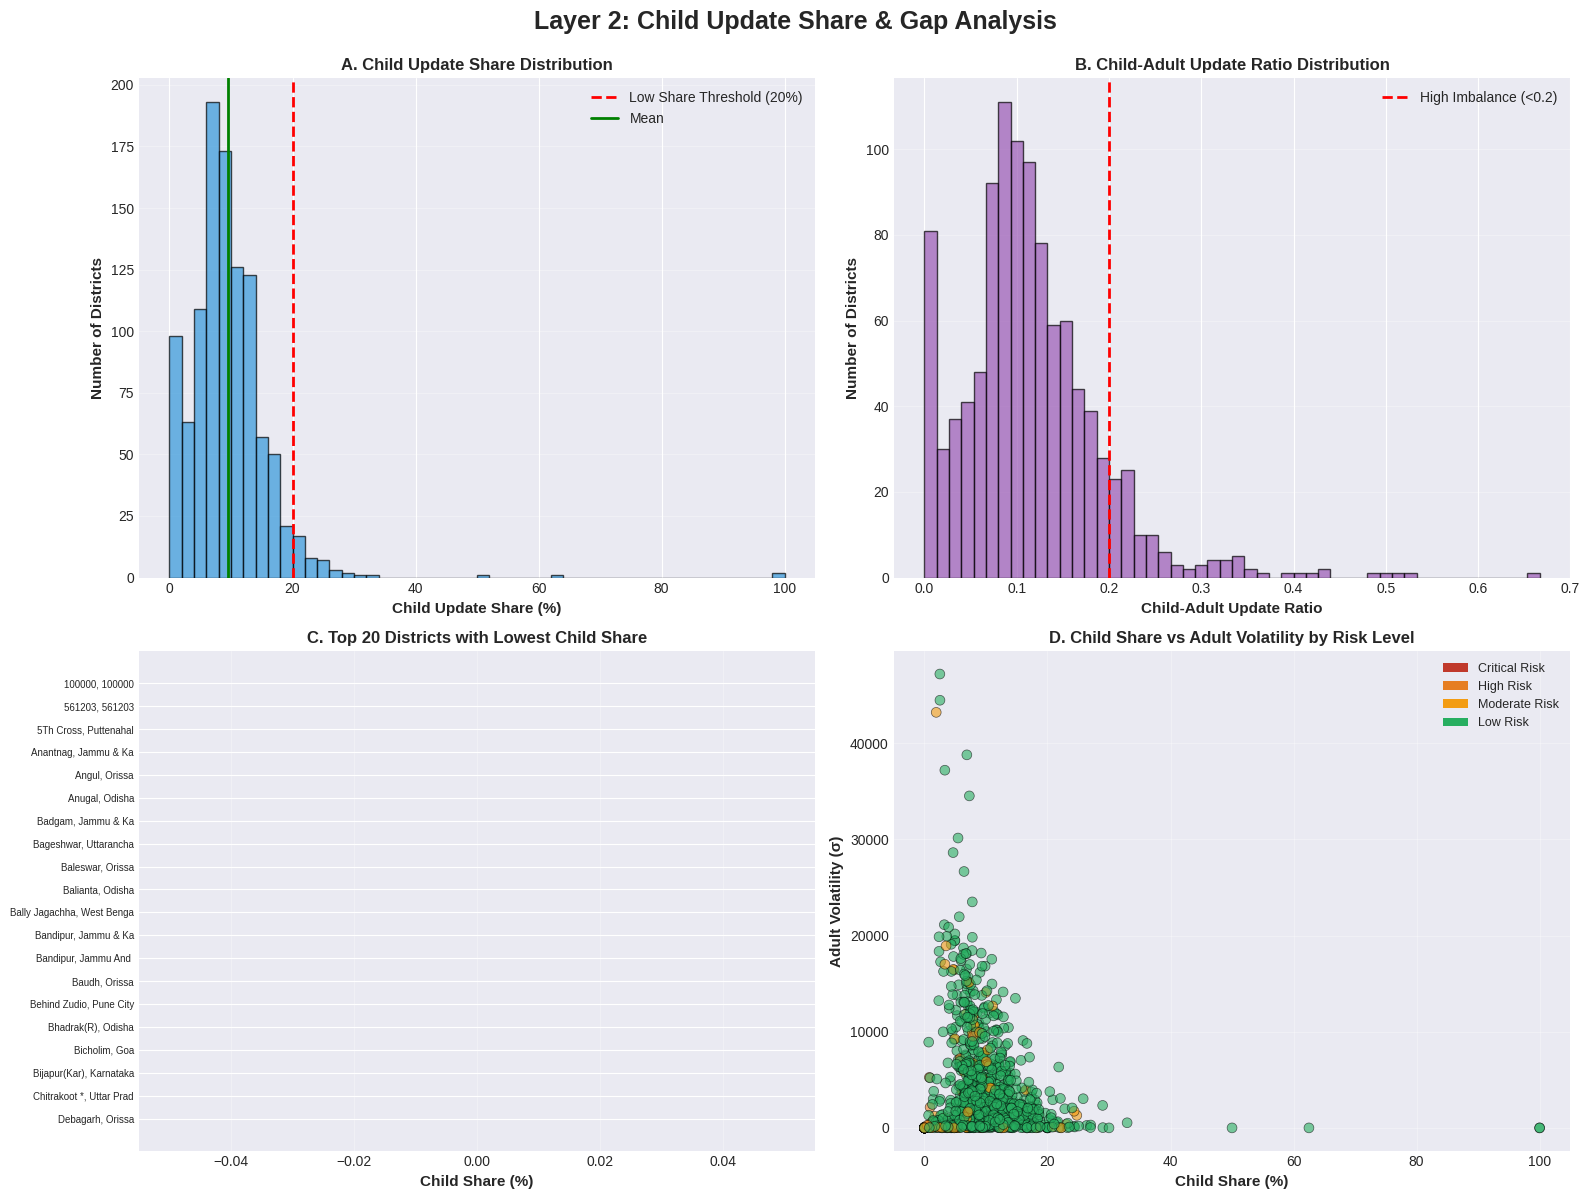

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Layer 2: Child Update Share & Gap Analysis', fontsize=18, fontweight='bold', y=0.995)

# 1. Child Share Distribution
ax1 = axes[0, 0]
ax1.hist(df_child_risk['child_share_pct'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(20, color='red', linestyle='--', linewidth=2, label='Low Share Threshold (20%)')
ax1.axvline(df_child_risk['child_share_pct'].mean(), color='green', linestyle='-', linewidth=2, label='Mean')
ax1.set_xlabel('Child Update Share (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Districts', fontsize=11, fontweight='bold')
ax1.set_title('A. Child Update Share Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Child-Adult Ratio Distribution
ax2 = axes[0, 1]
ratio_data = df_child_risk[df_child_risk['avg_child_adult_ratio'] < 2]  # Filter outliers
ax2.hist(ratio_data['avg_child_adult_ratio'], bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax2.axvline(0.2, color='red', linestyle='--', linewidth=2, label='High Imbalance (<0.2)')
ax2.set_xlabel('Child-Adult Update Ratio', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Districts', fontsize=11, fontweight='bold')
ax2.set_title('B. Child-Adult Update Ratio Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Top 20 Lowest Child Share Districts
ax3 = axes[1, 0]
bottom20 = df_child_risk.nsmallest(20, 'child_share_pct')
y_pos = np.arange(len(bottom20))
bars = ax3.barh(y_pos, bottom20['child_share_pct'], color='#e74c3c')
ax3.set_yticks(y_pos)
ax3.set_yticklabels([f"{row['district'][:15]}, {row['state'][:10]}" for _, row in bottom20.iterrows()], fontsize=7)
ax3.set_xlabel('Child Share (%)', fontsize=11, fontweight='bold')
ax3.set_title('C. Top 20 Districts with Lowest Child Share', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# 4. Child Share vs Adult Volatility
ax4 = axes[1, 1]
colors_risk = df_child_risk['risk_level'].map({
    'Critical': '#c0392b',
    'High': '#e67e22',
    'Moderate': '#f39c12',
    'Low': '#27ae60'
})
scatter = ax4.scatter(df_child_risk['child_share_pct'], df_child_risk['volatility'],
                     c=colors_risk, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Child Share (%)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Adult Volatility (σ)', fontsize=11, fontweight='bold')
ax4.set_title('D. Child Share vs Adult Volatility by Risk Level', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#c0392b', label='Critical Risk'),
                   Patch(facecolor='#e67e22', label='High Risk'),
                   Patch(facecolor='#f39c12', label='Moderate Risk'),
                   Patch(facecolor='#27ae60', label='Low Risk')]
ax4.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/layer2_child_share_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: layer2_child_share_analysis.png")
plt.show()

## 5. Visualization 2: Lag Detection & Temporal Patterns

✓ Saved: layer2_lag_detection.png


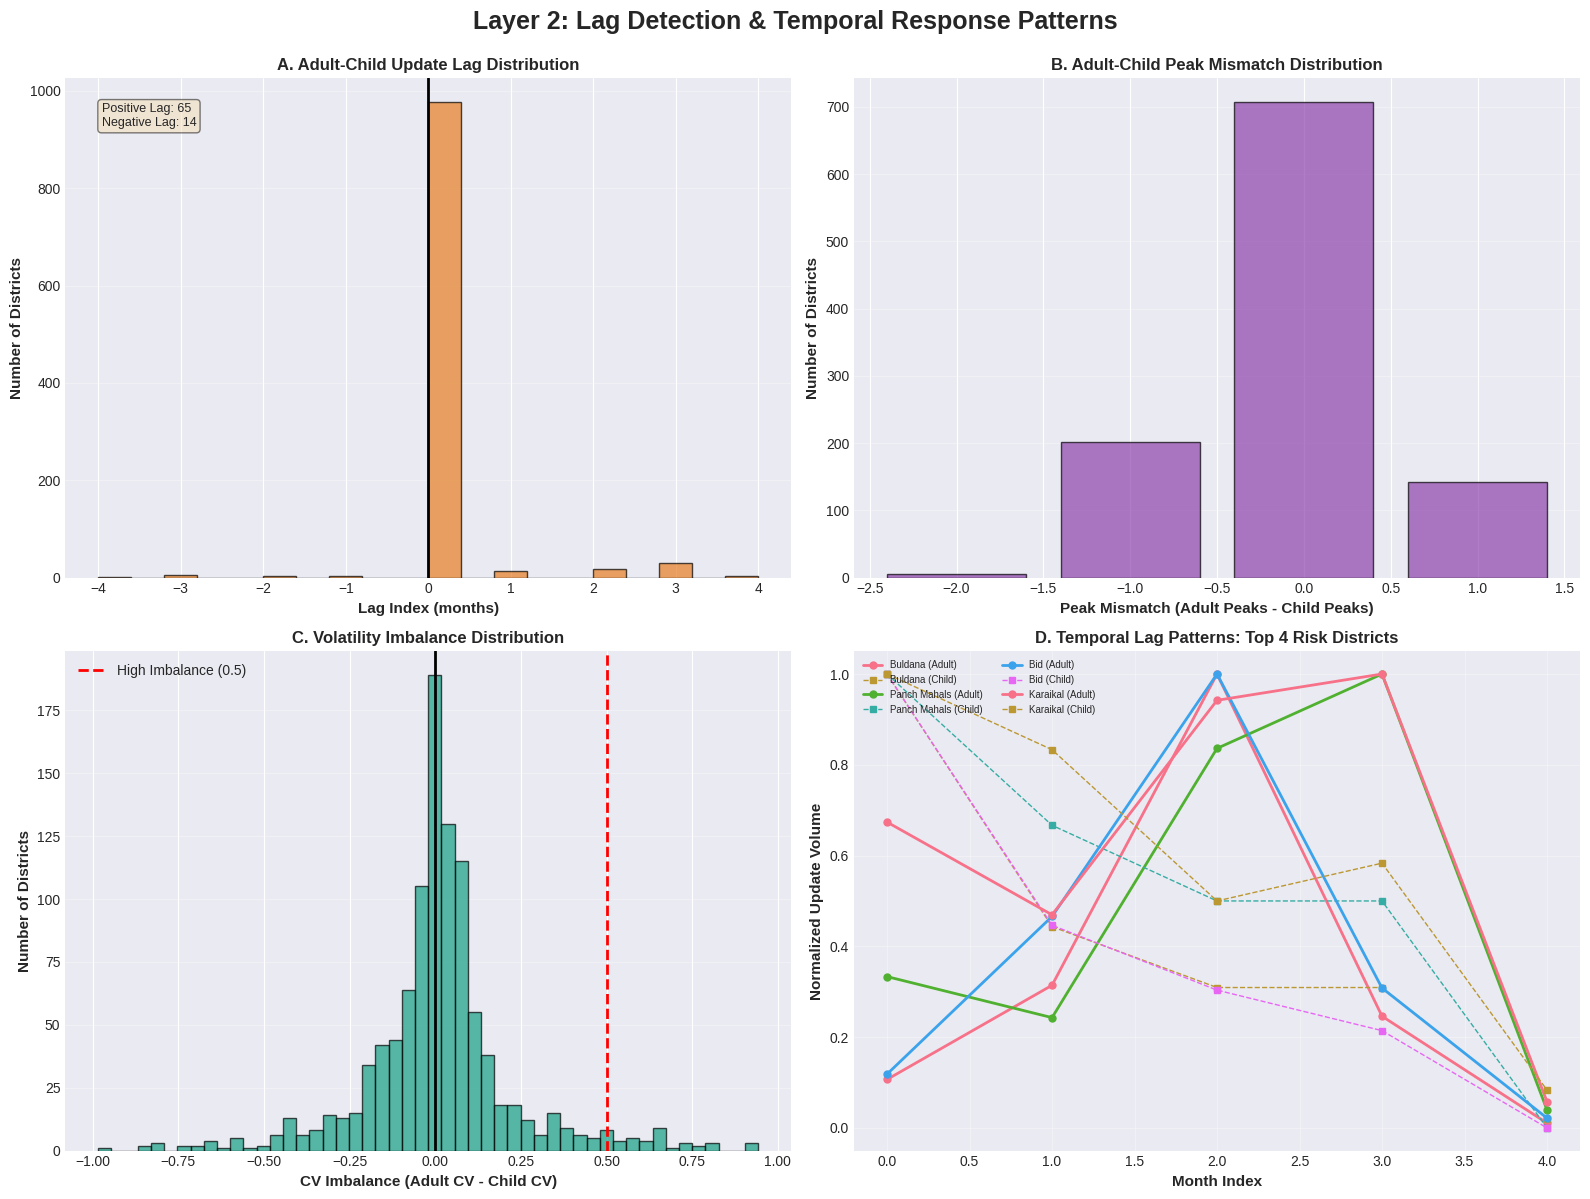

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Layer 2: Lag Detection & Temporal Response Patterns', fontsize=18, fontweight='bold', y=0.995)

# 1. Lag Index Distribution
ax1 = axes[0, 0]
lag_data = df_child_risk[df_child_risk['lag_index'].abs() < 5]  # Filter outliers
ax1.hist(lag_data['lag_index'], bins=20, color='#e67e22', alpha=0.7, edgecolor='black')
ax1.axvline(0, color='black', linestyle='-', linewidth=2)
ax1.set_xlabel('Lag Index (months)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Districts', fontsize=11, fontweight='bold')
ax1.set_title('A. Adult-Child Update Lag Distribution', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.text(0.05, 0.95, f"Positive Lag: {(df_child_risk['lag_index'] > 0).sum()}\nNegative Lag: {(df_child_risk['lag_index'] < 0).sum()}",
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Peak Mismatch Analysis
ax2 = axes[0, 1]
mismatch_counts = df_child_risk['peak_mismatch'].value_counts().sort_index()
ax2.bar(mismatch_counts.index, mismatch_counts.values, color='#8e44ad', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Peak Mismatch (Adult Peaks - Child Peaks)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Districts', fontsize=11, fontweight='bold')
ax2.set_title('B. Adult-Child Peak Mismatch Distribution', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. CV Imbalance (Volatility Imbalance)
ax3 = axes[1, 0]
cv_data = df_child_risk[(df_child_risk['cv_imbalance'] > -1) & (df_child_risk['cv_imbalance'] < 3)]
ax3.hist(cv_data['cv_imbalance'], bins=50, color='#16a085', alpha=0.7, edgecolor='black')
ax3.axvline(0, color='black', linestyle='-', linewidth=2)
ax3.axvline(0.5, color='red', linestyle='--', linewidth=2, label='High Imbalance (0.5)')
ax3.set_xlabel('CV Imbalance (Adult CV - Child CV)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Districts', fontsize=11, fontweight='bold')
ax3.set_title('C. Volatility Imbalance Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Time Series Examples (Top 4 Lag Districts)
ax4 = axes[1, 1]
top4_lag = df_child_risk[df_child_risk['lag_index'] > 0].nlargest(4, 'child_risk_score')
for idx, row in top4_lag.iterrows():
    district_data = df_monthly[(df_monthly['district'] == row['district']) & 
                               (df_monthly['state'] == row['state'])].sort_values('year_month')
    months = range(len(district_data))
    
    # Normalize for better visualization
    adult_norm = district_data['demo_age_17_'].values / district_data['demo_age_17_'].max()
    child_norm = district_data['demo_age_5_17'].values / district_data['demo_age_5_17'].max()
    
    ax4.plot(months, adult_norm, marker='o', linestyle='-', linewidth=2, markersize=5, 
            label=f"{row['district'][:12]} (Adult)")
    ax4.plot(months, child_norm, marker='s', linestyle='--', linewidth=1, markersize=4,
            label=f"{row['district'][:12]} (Child)")

ax4.set_xlabel('Month Index', fontsize=11, fontweight='bold')
ax4.set_ylabel('Normalized Update Volume', fontsize=11, fontweight='bold')
ax4.set_title('D. Temporal Lag Patterns: Top 4 Risk Districts', fontsize=12, fontweight='bold')
ax4.legend(fontsize=7, loc='upper left', ncol=2)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/layer2_lag_detection.png', dpi=300, bbox_inches='tight')
print("✓ Saved: layer2_lag_detection.png")
plt.show()

## 6. Visualization 3: Child Risk Score Analysis

✓ Saved: layer2_risk_score_analysis.png


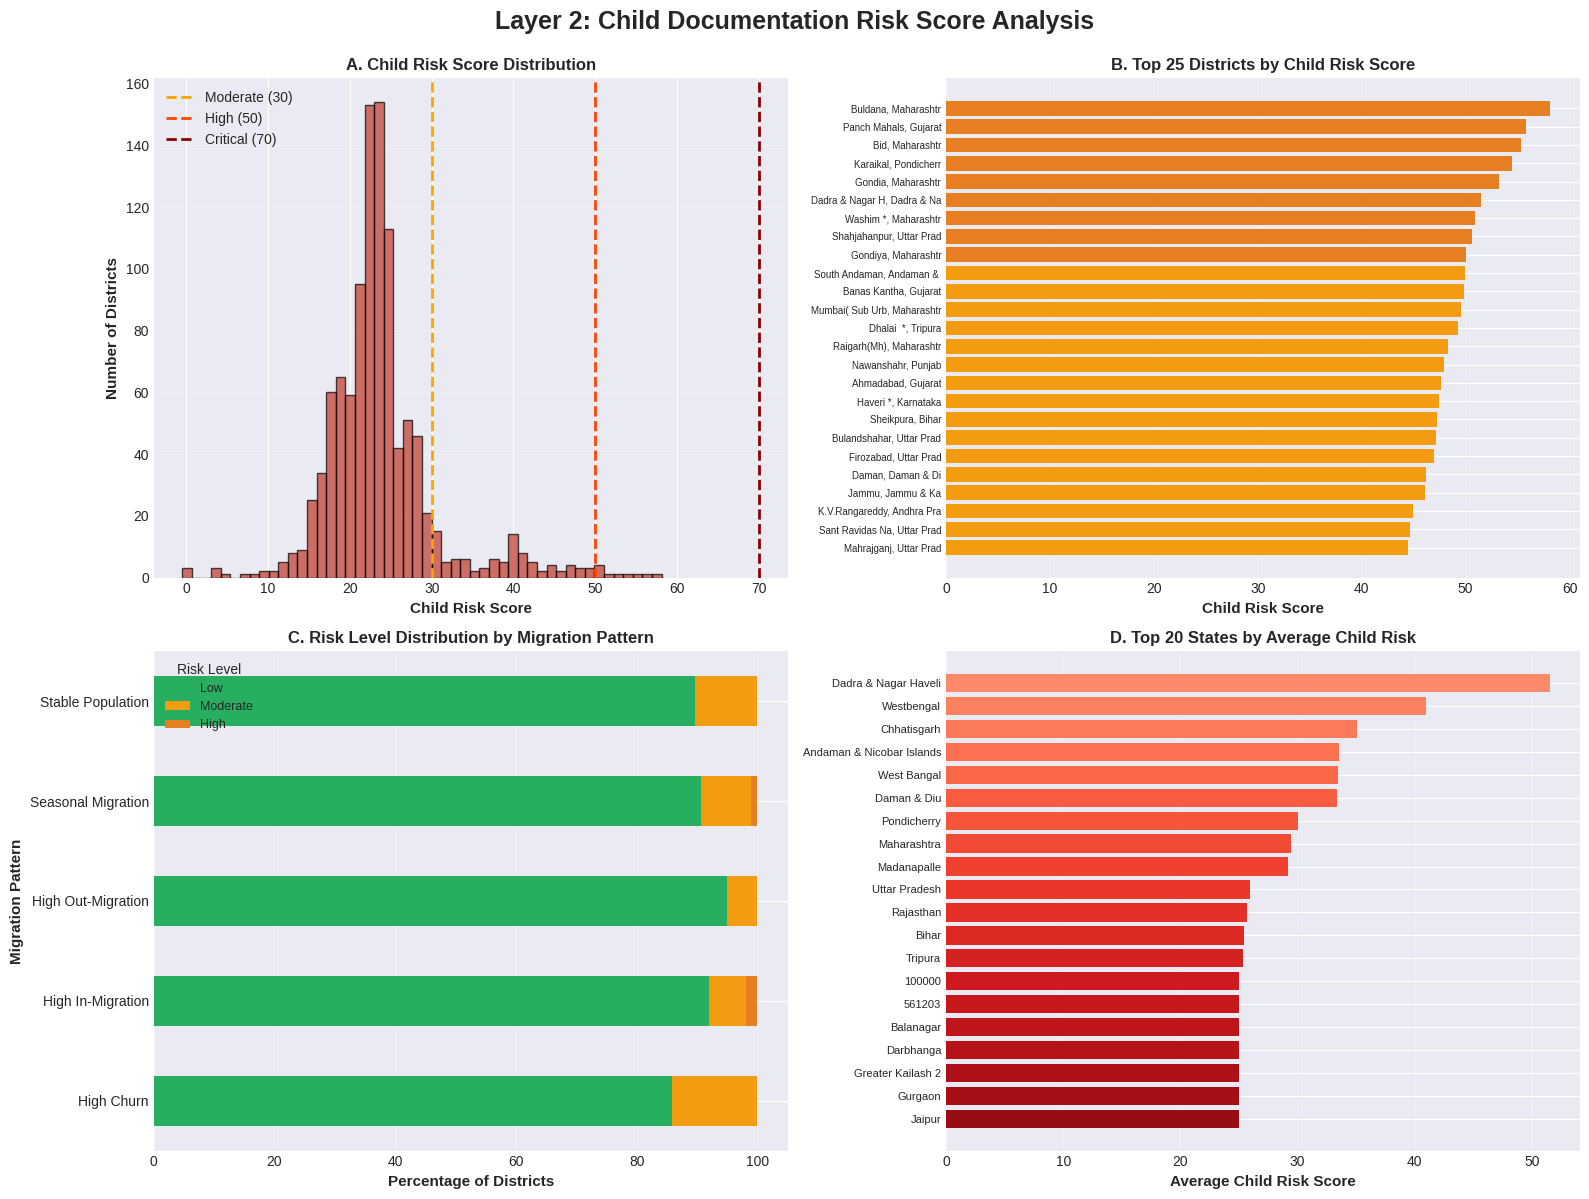

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Layer 2: Child Documentation Risk Score Analysis', fontsize=18, fontweight='bold', y=0.995)

# 1. Risk Score Distribution
ax1 = axes[0, 0]
ax1.hist(df_child_risk['child_risk_score'], bins=50, color='#c0392b', alpha=0.7, edgecolor='black')
ax1.axvline(30, color='orange', linestyle='--', linewidth=2, label='Moderate (30)')
ax1.axvline(50, color='orangered', linestyle='--', linewidth=2, label='High (50)')
ax1.axvline(70, color='darkred', linestyle='--', linewidth=2, label='Critical (70)')
ax1.set_xlabel('Child Risk Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Districts', fontsize=11, fontweight='bold')
ax1.set_title('A. Child Risk Score Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Top 25 Highest Risk Districts
ax2 = axes[0, 1]
top25_risk = df_child_risk.nlargest(25, 'child_risk_score')
y_pos = np.arange(len(top25_risk))
colors = [{'Critical': '#c0392b', 'High': '#e67e22', 'Moderate': '#f39c12', 'Low': '#27ae60'}[level] 
          for level in top25_risk['risk_level']]
bars = ax2.barh(y_pos, top25_risk['child_risk_score'], color=colors)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([f"{row['district'][:15]}, {row['state'][:10]}" for _, row in top25_risk.iterrows()], fontsize=7)
ax2.set_xlabel('Child Risk Score', fontsize=11, fontweight='bold')
ax2.set_title('B. Top 25 Districts by Child Risk Score', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# 3. Risk Level by Migration Pattern
ax3 = axes[1, 0]
risk_migration = pd.crosstab(df_child_risk['migration_pattern'], df_child_risk['risk_level'])
risk_migration_pct = risk_migration.div(risk_migration.sum(axis=1), axis=0) * 100
# Plot only existing risk levels
available_cols = [c for c in ['Low', 'Moderate', 'High', 'Critical'] if c in risk_migration_pct.columns]
if len(available_cols) > 0:
    risk_migration_pct[available_cols].plot(kind='barh', stacked=True, ax=ax3,
                                                                  color=['#27ae60', '#f39c12', '#e67e22', '#c0392b'])
ax3.set_xlabel('Percentage of Districts', fontsize=11, fontweight='bold')
ax3.set_ylabel('Migration Pattern', fontsize=11, fontweight='bold')
ax3.set_title('C. Risk Level Distribution by Migration Pattern', fontsize=12, fontweight='bold')
ax3.legend(title='Risk Level', fontsize=9)
ax3.grid(axis='x', alpha=0.3)

# 4. State-Level Risk Aggregation
ax4 = axes[1, 1]
state_risk = df_child_risk.groupby('state').agg({
    'child_risk_score': 'mean',
    'district': 'count'
}).reset_index()
state_risk = state_risk.nlargest(20, 'child_risk_score')

y_pos = np.arange(len(state_risk))
bars = ax4.barh(y_pos, state_risk['child_risk_score'],
                color=plt.cm.Reds(np.linspace(0.4, 0.9, len(state_risk))))
ax4.set_yticks(y_pos)
ax4.set_yticklabels(state_risk['state'], fontsize=8)
ax4.set_xlabel('Average Child Risk Score', fontsize=11, fontweight='bold')
ax4.set_title('D. Top 20 States by Average Child Risk', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/layer2_risk_score_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: layer2_risk_score_analysis.png")
plt.show()


## 7. Visualization 4: High Risk District Identification

Critical & High Risk Districts: 9

Top 15 Priority Districts for Intervention:
Buldana, Maharashtra: Risk=58.1, Share=0.8%, Pattern=High In-Migration
Panch Mahals, Gujarat: Risk=55.9, Share=3.6%, Pattern=Seasonal Migration
Bid, Maharashtra: Risk=55.3, Share=0.9%, Pattern=Seasonal Migration
Karaikal, Pondicherry: Risk=54.4, Share=3.4%, Pattern=Seasonal Migration
Gondia, Maharashtra: Risk=53.2, Share=1.6%, Pattern=Seasonal Migration
Dadra & Nagar Haveli, Dadra & Nagar Haveli: Risk=51.5, Share=12.2%, Pattern=Seasonal Migration
Washim *, Maharashtra: Risk=50.9, Share=0.5%, Pattern=Seasonal Migration
Shahjahanpur, Uttar Pradesh: Risk=50.6, Share=7.9%, Pattern=High In-Migration
Gondiya, Maharashtra: Risk=50.1, Share=5.8%, Pattern=High In-Migration



✓ Saved: layer2_high_risk_identification.png


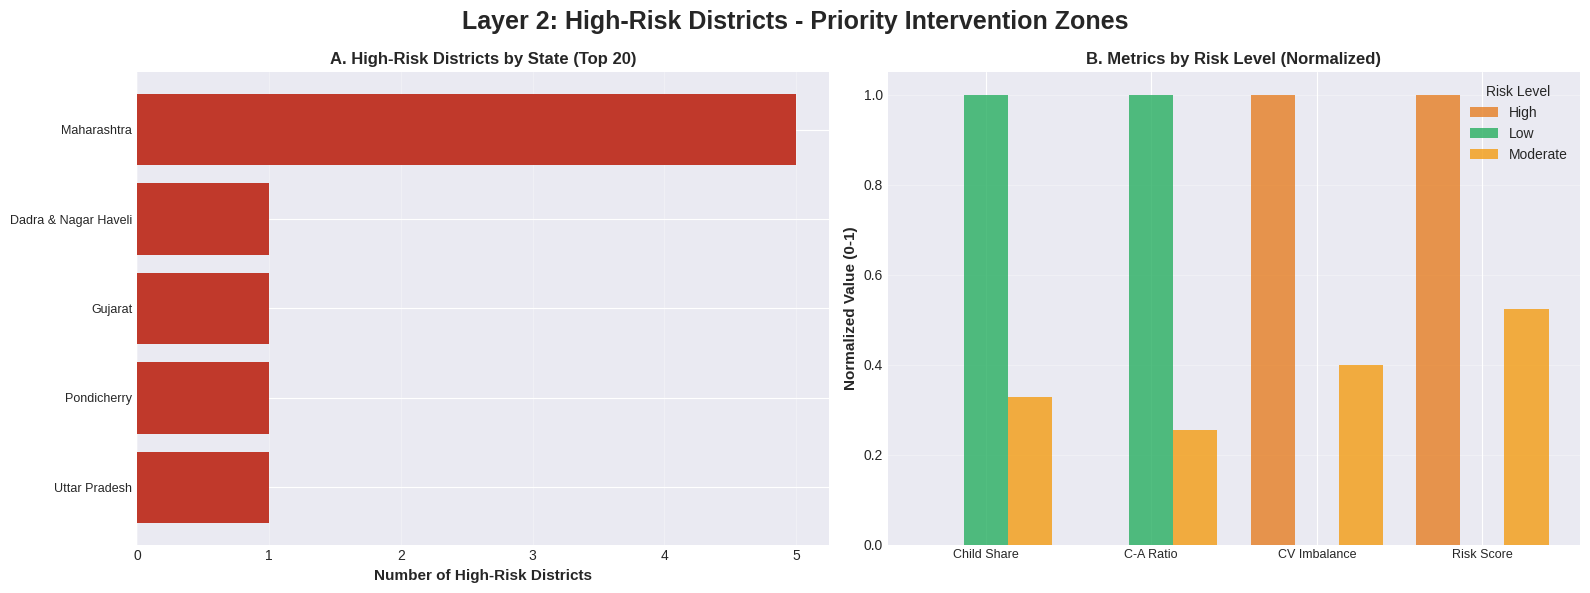

In [8]:
# Identify critical intervention zones
critical_districts = df_child_risk[df_child_risk['risk_level'].isin(['Critical', 'High'])]

print(f"Critical & High Risk Districts: {len(critical_districts)}")
print("\nTop 15 Priority Districts for Intervention:")
for idx, row in critical_districts.nlargest(15, 'child_risk_score').iterrows():
    print(f"{row['district']}, {row['state']}: Risk={row['child_risk_score']:.1f}, Share={row['child_share_pct']:.1f}%, Pattern={row['migration_pattern']}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Layer 2: High-Risk Districts - Priority Intervention Zones', 
             fontsize=18, fontweight='bold')

# 1. Geographic Distribution by State
ax1 = axes[0]
if len(critical_districts) > 0:
    state_critical = critical_districts.groupby('state').size().sort_values(ascending=False).head(20)
    y_pos = np.arange(len(state_critical))
    bars = ax1.barh(y_pos, state_critical.values, color='#c0392b')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(state_critical.index, fontsize=9)
    ax1.set_xlabel('Number of High-Risk Districts', fontsize=11, fontweight='bold')
    ax1.set_title('A. High-Risk Districts by State (Top 20)', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()
else:
    ax1.text(0.5, 0.5, 'No Critical/High Risk Districts', ha='center', va='center')

# 2. Comparison Matrix
ax2 = axes[1]
comparison = df_child_risk.groupby('risk_level').agg({
    'child_share_pct': 'mean',
    'avg_child_adult_ratio': 'mean',
    'cv_imbalance': 'mean',
    'child_risk_score': 'mean'
})

# Normalize for visualization
comparison_norm = (comparison - comparison.min()) / (comparison.max() - comparison.min())

x = np.arange(len(comparison_norm.columns))
width = 0.8 / max(len(comparison_norm), 1)

colors_map = {'Low': '#27ae60', 'Moderate': '#f39c12', 'High': '#e67e22', 'Critical': '#c0392b'}
for i, (risk_level, row) in enumerate(comparison_norm.iterrows()):
    color = colors_map.get(risk_level, '#95a5a6')
    ax2.bar(x + i*width, row.values, width, label=risk_level, color=color, alpha=0.8)

ax2.set_ylabel('Normalized Value (0-1)', fontsize=11, fontweight='bold')
ax2.set_title('B. Metrics by Risk Level (Normalized)', fontsize=12, fontweight='bold')
ax2.set_xticks(x + width * (len(comparison_norm)-1) / 2)
ax2.set_xticklabels(['Child Share', 'C-A Ratio', 'CV Imbalance', 'Risk Score'], fontsize=9)
ax2.legend(title='Risk Level', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/layer2_high_risk_identification.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: layer2_high_risk_identification.png")
plt.show()



## 8. Export Results

In [9]:
# Save child risk metrics
df_child_risk.to_csv('../outputs/layer2_child_risk_metrics.csv', index=False)
print("✓ Saved: layer2_child_risk_metrics.csv")

# Save critical districts
critical_districts.to_csv('../outputs/layer2_critical_districts.csv', index=False)
print("✓ Saved: layer2_critical_districts.csv")

# Generate summary report
summary_text = f"""
LAYER 2: CHILD DOCUMENTATION RISK MAP - SUMMARY REPORT
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'=' * 80}

DATASET OVERVIEW
- Total Districts Analyzed: {len(df_child_risk)}
- Date Range: {df_monthly['year_month'].min()} to {df_monthly['year_month'].max()}

CHILD UPDATE PATTERNS
- Mean Child Share: {df_child_risk['child_share_pct'].mean():.2f}%
- Median Child Share: {df_child_risk['child_share_pct'].median():.2f}%
- Low Share Districts (<20%): {(df_child_risk['child_share_pct'] < 20).sum()}
- Mean Child-Adult Ratio: {df_child_risk['avg_child_adult_ratio'].mean():.3f}

LAG DETECTION
- Districts with Positive Lag: {(df_child_risk['lag_index'] > 0).sum()}
- Districts with Adult Spike: {df_child_risk['has_adult_spike'].sum()}
- Districts with Child Response: {df_child_risk['has_child_response'].sum()}
- Districts with Peak Mismatch: {(df_child_risk['peak_mismatch'] > 0).sum()}

RISK ASSESSMENT
- Mean Risk Score: {df_child_risk['child_risk_score'].mean():.2f}
- Critical Risk Districts: {(df_child_risk['risk_level'] == 'Critical').sum()}
- High Risk Districts: {(df_child_risk['risk_level'] == 'High').sum()}
- Moderate Risk Districts: {(df_child_risk['risk_level'] == 'Moderate').sum()}
- Low Risk Districts: {(df_child_risk['risk_level'] == 'Low').sum()}

RISK LEVEL DISTRIBUTION
{df_child_risk['risk_level'].value_counts().to_string()}

TOP 10 HIGHEST RISK DISTRICTS:
"""

for i, (idx, row) in enumerate(df_child_risk.nlargest(10, 'child_risk_score').iterrows(), 1):
    summary_text += f"{i}. {row['district']}, {row['state']}: Risk={row['child_risk_score']:.1f}, Share={row['child_share_pct']:.1f}%, Lag={row['lag_index']}, Pattern={row['migration_pattern']}\n"

summary_text += f"""
CORRELATION WITH MIGRATION
Average Risk by Migration Pattern:
"""

for pattern, score in df_child_risk.groupby('migration_pattern')['child_risk_score'].mean().sort_values(ascending=False).items():
    summary_text += f"- {pattern}: {score:.2f}\n"

summary_text += f"""
{'=' * 80}
VISUALIZATIONS GENERATED:
1. layer2_child_share_analysis.png - Child share & gap patterns
2. layer2_lag_detection.png - Temporal lag analysis
3. layer2_risk_score_analysis.png - Risk scoring & distribution
4. layer2_high_risk_identification.png - Priority intervention zones

DATA OUTPUTS:
1. layer2_child_risk_metrics.csv - Complete metrics for all districts
2. layer2_critical_districts.csv - Critical & high risk districts

{'=' * 80}
POLICY IMPLICATIONS:
- Mobile Aadhaar enrollment camps needed in high-risk districts
- School-based documentation drives for child welfare access
- Awareness campaigns linking child Aadhaar to education/health benefits
- Targeted outreach to migrant families with children

NEXT STEPS:
- Cross-validate with school enrollment data
- Integrate with PDS beneficiary data
- Proceed to Layer 3A: Stability Index
"""

with open('../outputs/layer2_summary_report.txt', 'w') as f:
    f.write(summary_text)

print("✓ Saved: layer2_summary_report.txt")
print("\n" + summary_text)

✓ Saved: layer2_child_risk_metrics.csv
✓ Saved: layer2_critical_districts.csv
✓ Saved: layer2_summary_report.txt


LAYER 2: CHILD DOCUMENTATION RISK MAP - SUMMARY REPORT
Generated: 2026-01-15 14:42:53

DATASET OVERVIEW
- Total Districts Analyzed: 1056
- Date Range: 2025-03 to 2026-01

CHILD UPDATE PATTERNS
- Mean Child Share: 9.48%
- Median Child Share: 8.84%
- Low Share Districts (<20%): 1013
- Mean Child-Adult Ratio: 0.116

LAG DETECTION
- Districts with Positive Lag: 65
- Districts with Adult Spike: 966
- Districts with Child Response: 949
- Districts with Peak Mismatch: 142

RISK ASSESSMENT
- Mean Risk Score: 23.78
- Critical Risk Districts: 0
- High Risk Districts: 9
- Moderate Risk Districts: 93
- Low Risk Districts: 954

RISK LEVEL DISTRIBUTION
risk_level
Low         954
Moderate     93
High          9

TOP 10 HIGHEST RISK DISTRICTS:
1. Buldana, Maharashtra: Risk=58.1, Share=0.8%, Lag=2, Pattern=High In-Migration
2. Panch Mahals, Gujarat: Risk=55.9, Share=3.6%, Lag=2, Pattern=Se

## 9. Conclusions

### Key Findings:

1. **Child Share Disparity**: Significant variation in child update proportions across districts
2. **Lag Patterns**: Measurable temporal lag between adult spikes and child responses
3. **Welfare Gap Proxy**: High volatility imbalance indicates potential welfare access barriers
4. **Geographic Clusters**: Certain states show concentrated high-risk patterns
5. **Migration Correlation**: High-churn migration zones show elevated child risk

### Policy Implications:

- **Mobile Enrollment**: Deploy mobile camps to high-risk districts
- **School Integration**: Integrate Aadhaar enrollment with school admissions
- **Awareness Campaigns**: Link child documentation to welfare scheme eligibility
- **Migrant Outreach**: Specialized programs for migrant families with children

**Status: Layer 2 Implementation Complete ✓**